## Домашнее задание к уроку 2: Линейная и логистическая регрессия
## Цель задания
## Закрепить навыки работы с PyTorch API, изучить модификацию моделей и работу с различными датасетами.

Задание 1: Модификация существующих моделей (30 баллов)
Создайте файл homework_model_modification.py:


### Скопирую код с пары

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures

In [23]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [24]:
def make_regression_data(n=100, noise=0.1, source='random'):
    if source == 'random':
        X = torch.rand(n, 1)
        w, b = 2.0, -1.0
        y = w * X + b + noise * torch.randn(n, 1)
        return X, y
    elif source == 'diabetes':
        from sklearn.datasets import load_diabetes
        data = load_diabetes()
        X = torch.tensor(data['data'], dtype=torch.float32)
        y = torch.tensor(data['target'], dtype=torch.float32).unsqueeze(1)
        return X, y
    else:
        raise ValueError('Unknown source')

In [25]:
def make_classification_data(n=100, source='random'):
    if source == 'random':
        X = torch.rand(n, 2)
        w = torch.tensor([2.0, -3.0])
        b = 0.5
        logits = X @ w + b
        y = (logits > 0).float().unsqueeze(1)
        return X, y
    elif source == 'breast_cancer':
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer()
        X = torch.tensor(data['data'], dtype=torch.float32)
        y = torch.tensor(data['target'], dtype=torch.float32).unsqueeze(1)
        return X, y
    else:
        raise ValueError('Unknown source')

In [26]:
def mse(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean().item()

def accuracy(y_pred, y_true):
    y_pred_bin = (y_pred > 0.5).float()
    return (y_pred_bin == y_true).float().mean().item()

def log_epoch(epoch, loss, **metrics):
    msg = f"Epoch {epoch}: loss={loss:.4f}"
    for k, v in metrics.items():
        msg += f", {k}={v:.4f}"
    print(msg)

In [27]:
class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x)

In [28]:
X, y = make_regression_data(n=200)

    # Создаём датасет и даталоадер
dataset = RegressionDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f'Размер датасета: {len(dataset)}')
print(f'Количество батчей: {len(dataloader)}')

Размер датасета: 200
Количество батчей: 7


1.1 Расширение линейной регрессии (15 баллов)
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию

## Добавим l1 и l2 регуляризации, добавив к ошибке l1 и l2

In [29]:
def compute_regularization_loss(model, l1_coef=0.0, l2_coef=0.0):
    l1_loss, l2_loss = 0.0, 0.0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
        l2_loss += torch.sum(param ** 2)
    return l1_coef * l1_loss + l2_coef * l2_loss

# - Добавьте early stopping

## Для early stopping нужно разделить данные на train и val части и на каждой эпохе считать ошибку на val выборке

In [30]:

X_train, X_val, y_train, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

train_dataset = RegressionDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = RegressionDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [31]:
# Создаём модель, функцию потерь и оптимизатор
model = LinearRegression(in_features=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Обучаем модель
l1_coef = 1e-4
l2_coef = 1e-4
patience = 10 # количество эпох без обучения
best_val_loss = np.inf
epochs_no_improve = 0

epochs = 100
for epoch in range(1, epochs + 1):
    train_loss = 0

    for i, (batch_X, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        reg_loss = compute_regularization_loss(model, l1_coef, l2_coef)
        total_batch_loss = loss + reg_loss

        total_batch_loss.backward()
        optimizer.step()

        train_loss += total_batch_loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_X, val_y in val_loader:
            val_pred = model(val_X)
            loss_val = criterion(val_pred, val_y)
            val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader)

    log_epoch(epoch, avg_train_loss, val_loss=avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_linreg_torch.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping на эпохе {epoch}")
        break
# Сохраняем модель
torch.save(model.state_dict(), 'linreg_torch.pth')

# Загружаем модель
new_model = LinearRegression(in_features=1)
new_model.load_state_dict(torch.load('linreg_torch.pth'))
new_model.eval()

Epoch 1: loss=0.5773, val_loss=0.1219
Epoch 2: loss=0.2243, val_loss=0.1001
Epoch 3: loss=0.1928, val_loss=0.0855
Epoch 4: loss=0.1583, val_loss=0.0694
Epoch 5: loss=0.1338, val_loss=0.0573
Epoch 6: loss=0.1191, val_loss=0.0473
Epoch 7: loss=0.1049, val_loss=0.0397
Epoch 8: loss=0.0763, val_loss=0.0336
Epoch 9: loss=0.0657, val_loss=0.0308
Epoch 10: loss=0.0606, val_loss=0.0252
Epoch 11: loss=0.0547, val_loss=0.0221
Epoch 12: loss=0.0462, val_loss=0.0205
Epoch 13: loss=0.0397, val_loss=0.0188
Epoch 14: loss=0.0339, val_loss=0.0171
Epoch 15: loss=0.0326, val_loss=0.0152
Epoch 16: loss=0.0313, val_loss=0.0149
Epoch 17: loss=0.0283, val_loss=0.0136
Epoch 18: loss=0.0252, val_loss=0.0133
Epoch 19: loss=0.0246, val_loss=0.0128
Epoch 20: loss=0.0224, val_loss=0.0125
Epoch 21: loss=0.0218, val_loss=0.0124
Epoch 22: loss=0.0202, val_loss=0.0123
Epoch 23: loss=0.0190, val_loss=0.0126
Epoch 24: loss=0.0199, val_loss=0.0124
Epoch 25: loss=0.0181, val_loss=0.0124
Epoch 26: loss=0.0173, val_loss=0.

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

# 1.2 Расширение логистической регрессии (15 баллов)
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix

In [32]:

class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.linear(x)


## Функции для вычисления метрик и для вывода confusion_matrix, используя sklearn

In [33]:


def compute_metrics(y_true, y_pred_logits):
    y_pred_labels = y_pred_logits.argmax(dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)

    try:
        y_true_oh = np.eye(np.max(y_true)+1)[y_true]
        roc_auc = roc_auc_score(y_true_oh, y_pred_logits.softmax(dim=1).cpu().numpy(), multi_class='ovr')
    except ValueError:
        roc_auc = np.nan  # если данные некорректны для ROC-AUC

    return precision, recall, f1, roc_auc

def plot_confusion_matrix(y_true, y_pred_labels, labels):
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

## Разделим данные на train и val для вычисления метрик на val выборке

In [34]:

# Генерируем данные
X, y = make_classification_data(n=200)

# Разбиваем на train/val
X_train, X_val, y_train, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

train_dataset = ClassificationDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = ClassificationDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Размер train-датасета: {len(train_dataset)}')
print(f'Размер val-датасета: {len(val_dataset)}')

Размер train-датасета: 160
Размер val-датасета: 40


Epoch 1: loss=0.7723, acc=0.4188, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 2: loss=0.7629, acc=0.4062, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 3: loss=0.7538, acc=0.4062, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 4: loss=0.7453, acc=0.4250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 5: loss=0.7375, acc=0.4562, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 6: loss=0.7290, acc=0.4625, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 7: loss=0.7211, acc=0.4813, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 8: loss=0.7137, acc=0.5062, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 9: loss=0.7072, acc=0.5188, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 10: loss=0.6990, acc=0.5188, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 11: loss=0.6921, acc=0.5188, precision=0.0000, recall=0.0000, f

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Epoch 16: loss=0.6588, acc=0.7000, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 17: loss=0.6526, acc=0.7250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 18: loss=0.6466, acc=0.7438, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 19: loss=0.6409, acc=0.7812, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 20: loss=0.6345, acc=0.7688, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 21: loss=0.6288, acc=0.8063, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 22: loss=0.6231, acc=0.8250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 23: loss=0.6180, acc=0.8313, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 24: loss=0.6129, acc=0.8250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 25: loss=0.6069, acc=0.8562, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 26: loss=0.6017, acc=0.8625, precision=0.0000, recall=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Epoch 34: loss=0.5635, acc=0.9125, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 35: loss=0.5594, acc=0.9062, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 36: loss=0.5551, acc=0.9125, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 37: loss=0.5512, acc=0.9313, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 38: loss=0.5467, acc=0.9187, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 39: loss=0.5425, acc=0.9187, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 40: loss=0.5387, acc=0.9250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 41: loss=0.5349, acc=0.9187, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 42: loss=0.5309, acc=0.9250, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 43: loss=0.5274, acc=0.9187, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 44: loss=0.5237, acc=0.9313, precision=0.0000, recall=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Epoch 51: loss=0.4994, acc=0.9313, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 52: loss=0.4962, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 53: loss=0.4930, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 54: loss=0.4899, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 55: loss=0.4868, acc=0.9313, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 56: loss=0.4837, acc=0.9437, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 57: loss=0.4809, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 58: loss=0.4783, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 59: loss=0.4754, acc=0.9375, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 60: loss=0.4723, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 61: loss=0.4696, acc=0.9437, precision=0.0000, recall=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Epoch 70: loss=0.4469, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 71: loss=0.4445, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 72: loss=0.4421, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 73: loss=0.4397, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 74: loss=0.4379, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 75: loss=0.4353, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 76: loss=0.4334, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 77: loss=0.4312, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 78: loss=0.4291, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 79: loss=0.4266, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 80: loss=0.4246, acc=0.9563, precision=0.0000, recall=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Epoch 87: loss=0.4111, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 88: loss=0.4094, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 89: loss=0.4076, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 90: loss=0.4056, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 91: loss=0.4040, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 92: loss=0.4022, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 93: loss=0.4005, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 94: loss=0.3989, acc=0.9500, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 95: loss=0.3969, acc=0.9563, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 96: loss=0.3953, acc=0.9625, precision=0.0000, recall=0.0000, f1=0.0000, roc_auc=0.5000
Epoch 97: loss=0.3938, acc=0.9625, precision=0.0000, recall=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

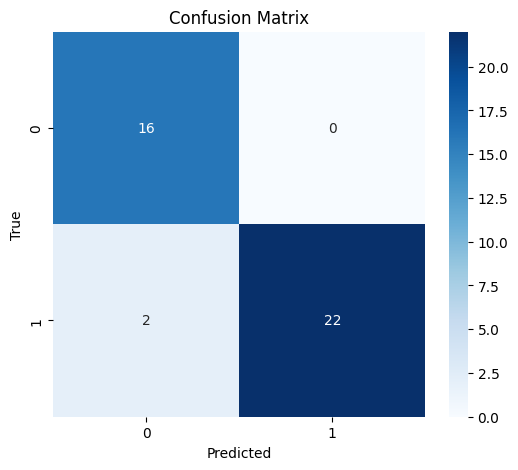

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [35]:
# Создаём модель, функцию потерь и оптимизатор
model = LogisticRegression(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Обучаем модель
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    total_acc = 0

    for i, (batch_X, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        y_pred = torch.sigmoid(logits)
        acc = accuracy(y_pred, batch_y)

        total_loss += loss.item()
        total_acc += acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)

    # Validation
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            logits = model(val_X)
            all_preds.append(torch.sigmoid(logits))
            all_targets.append(val_y)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets).long().squeeze()

    precision, recall, f1, roc_auc = compute_metrics(all_targets, all_preds)
    log_epoch(epoch, avg_loss, acc=avg_acc, precision=precision, recall=recall, f1=f1, roc_auc=roc_auc)

    if epoch == epochs:
        y_pred_labels = (all_preds > 0.5).int().cpu().numpy()
        plot_confusion_matrix(all_targets.cpu().numpy(), y_pred_labels, labels=["0", "1"])

# Сохраняем модель
torch.save(model.state_dict(), 'logreg_torch.pth')

# Загружаем модель
new_model = LogisticRegression(2, 1)
new_model.load_state_dict(torch.load('logreg_torch.pth'))
new_model.eval()

# 2.1 Кастомный Dataset класс (15 баллов)
# Создайте кастомный класс датасета для работы с CSV файлами:
# - Загрузка данных из файла
# - Предобработка (нормализация, кодирование категорий)
# - Поддержка различных форматов данных (категориальные, числовые, бинарные и т.д.)

### Кастомный класс датасета (обработка разных типов данных)

In [36]:

class CSVDataset(Dataset):
    def __init__(self, csv_path, target_col, cat_cols=None, binary_cols=None):
        """
        csv_path: путь к csv-файлу
        target_col: название колонки target
        cat_cols: список категориальных колонок
        binary_cols: список бинарных колонок (0/1)
        """
        self.data = pd.read_csv(csv_path)
        self.target_col = target_col
        self.cat_cols = cat_cols if cat_cols else []
        self.binary_cols = binary_cols if binary_cols else []

        # Выделяем целевую переменную
        self.y = torch.tensor(self.data[target_col].values, dtype=torch.float32).unsqueeze(1)

        # Убираем целевую колонку из данных
        X_data = self.data.drop(columns=[target_col])

        # Работа с категориальными колонками
        if self.cat_cols:
            cat_data = X_data[self.cat_cols]
            encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
            cat_encoded = encoder.fit_transform(cat_data)
            self.cat_tensor = torch.tensor(cat_encoded, dtype=torch.float32)
        else:
            self.cat_tensor = None

        # Работа с бинарными колонками
        if self.binary_cols:
            bin_data = X_data[self.binary_cols].astype(float)
            self.bin_tensor = torch.tensor(bin_data.values, dtype=torch.float32)
        else:
            self.bin_tensor = None

        # Числовые колонки
        num_cols = [col for col in X_data.columns if col not in self.cat_cols + self.binary_cols]
        if num_cols:
            num_data = X_data[num_cols]
            scaler = StandardScaler()
            num_scaled = scaler.fit_transform(num_data)
            self.num_tensor = torch.tensor(num_scaled, dtype=torch.float32)
        else:
            self.num_tensor = None

        tensors = [t for t in [self.cat_tensor, self.bin_tensor, self.num_tensor] if t is not None]
        if not tensors:
            raise ValueError("Не удалось собрать данные: ни одна из категориальных, бинарных или числовых колонок не найдена.")
        self.X = torch.cat(tensors, dim=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 2.2 Эксперименты с различными датасетами (15 баллов)

# Найдите csv датасеты для регрессии и бинарной классификации и, применяя наработки из предыдущей части задания, обучите линейную и логистическую регрессию

# Использую учебные датасеты load_diabetes, load_breast_cancer из sklearn для регрессии и бинарной классификации соответственно

In [37]:
from sklearn.datasets import load_diabetes, load_breast_cancer

# 1. Diabetes для регрессии
diabetes = load_diabetes()
X_diabetes = pd.DataFrame(diabetes['data'], columns=diabetes['feature_names'])
y_diabetes = pd.Series(diabetes['target'], name="target")
df_diabetes = pd.concat([X_diabetes, y_diabetes], axis=1)
df_diabetes.to_csv("diabetes.csv", index=False)

# 2. Breast Cancer для бинарной классификации
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
y_cancer = pd.Series(cancer['target'], name="target")
df_cancer = pd.concat([X_cancer, y_cancer], axis=1)
df_cancer.to_csv("breast_cancer.csv", index=False)


### Регрессия (diebetes)

In [40]:
reg_dataset = CSVDataset("diabetes.csv", target_col="target")
reg_loader = DataLoader(reg_dataset, batch_size=32, shuffle=True)

model = nn.Linear(reg_dataset.X.shape[1], 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(1, epochs+1):
    total_loss = 0
    for X_batch, y_batch in reg_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(reg_loader)
    if epoch % 10 == 0:
        print(f"[Diabetes] Epoch {epoch}: loss={avg_loss:.4f}")

torch.save(model.state_dict(), "diabetes_model.pth")


[Diabetes] Epoch 10: loss=3019.7631
[Diabetes] Epoch 20: loss=2901.2206
[Diabetes] Epoch 30: loss=2888.6868
[Diabetes] Epoch 40: loss=2903.8845
[Diabetes] Epoch 50: loss=2906.3699
[Diabetes] Epoch 60: loss=2881.4439
[Diabetes] Epoch 70: loss=2901.7529
[Diabetes] Epoch 80: loss=2885.1980
[Diabetes] Epoch 90: loss=2892.5126
[Diabetes] Epoch 100: loss=2891.9354


### Классификация(breast_cancer)

In [41]:
clf_dataset = CSVDataset("breast_cancer.csv", target_col="target")
clf_loader = DataLoader(clf_dataset, batch_size=32, shuffle=True)

model = LogisticRegression(clf_dataset.X.shape[1],1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(1, epochs+1):
    total_loss, total_acc = 0, 0
    for X_batch, y_batch in clf_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        y_pred = torch.sigmoid(logits) > 0.5
        acc = (y_pred == y_batch).float().mean().item()
        total_loss += loss.item()
        total_acc += acc
    avg_loss = total_loss / len(clf_loader)
    avg_acc = total_acc / len(clf_loader)
    if epoch % 10 == 0:
        print(f"[BreastCancer] Epoch {epoch}: loss={avg_loss:.4f}, acc={avg_acc:.4f}")

torch.save(model.state_dict(), "breast_cancer_model.pth")



[BreastCancer] Epoch 10: loss=0.2025, acc=0.9608
[BreastCancer] Epoch 20: loss=0.1476, acc=0.9705
[BreastCancer] Epoch 30: loss=0.1262, acc=0.9747
[BreastCancer] Epoch 40: loss=0.1131, acc=0.9774
[BreastCancer] Epoch 50: loss=0.1049, acc=0.9792
[BreastCancer] Epoch 60: loss=0.1001, acc=0.9817
[BreastCancer] Epoch 70: loss=0.0948, acc=0.9826
[BreastCancer] Epoch 80: loss=0.0913, acc=0.9826
[BreastCancer] Epoch 90: loss=0.0878, acc=0.9826
[BreastCancer] Epoch 100: loss=0.0857, acc=0.9844


3.1 Исследование гиперпараметров (10 баллов)
# Проведите эксперименты с различными:
# - Скоростями обучения (learning rate)
# - Размерами батчей
# - Оптимизаторами (SGD, Adam, RMSprop)
# Визуализируйте результаты в виде графиков или таблиц
3.2 Feature Engineering (10 баллов)
# Создайте новые признаки для улучшения модели:
# - Полиномиальные признаки
# - Взаимодействия между признаками
# - Статистические признаки (среднее, дисперсия)
# Сравните качество с базовой моделью

In [52]:
def train_and_evaluate_simple(model_class, input_dim, train_loader, val_loader, criterion, optimizer_class, lr, epochs, device):
    model = model_class(input_dim, 1).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    total_val_loss, total_val_acc = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            y_pred = (torch.sigmoid(logits) > 0.5).float()
            acc = (y_pred == y_batch).float().mean().item()

            total_val_loss += loss.item()
            total_val_acc += acc

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)

    return avg_val_acc, avg_val_loss, model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 100
criterion = nn.BCEWithLogitsLoss()

print("--- Запуск экспериментов с гиперпараметрами и оптимизаторами ---")
# Эксперименты с гиперпараметрами
experiments = [
    {"lr": 0.1, "batch_size": 32, "optimizer": "SGD"},
    {"lr": 0.01, "batch_size": 64, "optimizer": "Adam"},
    {"lr": 0.001, "batch_size": 16, "optimizer": "RMSprop"},
    {"lr": 0.05, "batch_size": 32, "optimizer": "Adam"},
]

optimizer_map = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "RMSprop": optim.RMSprop
}

results = []
best_val_acc_so_far = -1
best_params_for_baseline = {}
best_model_for_baseline = None

base_clf_dataset = CSVDataset("breast_cancer.csv", target_col="target")

X_base_train, X_base_val, y_base_train, y_base_val = train_test_split(
    base_clf_dataset.X, base_clf_dataset.y, test_size=0.2, random_state=42, stratify=base_clf_dataset.y
)
train_dataset_base = torch.utils.data.TensorDataset(X_base_train, y_base_train)
val_dataset_base = torch.utils.data.TensorDataset(X_base_val, y_base_val)

input_dim_base = X_base_train.shape[1]

for exp_num, params in enumerate(experiments):
    lr = params["lr"]
    bs = params["batch_size"]
    opt_name = params["optimizer"]
    opt_class = optimizer_map[opt_name]

    train_loader = DataLoader(train_dataset_base, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset_base, batch_size=bs, shuffle=False)

    print(f"Эксперимент {exp_num + 1}: LR={lr}, BS={bs}, Оптимизатор={opt_name}")
    val_acc, val_loss, current_model = train_and_evaluate_simple(
        LogisticRegression, input_dim_base, train_loader, val_loader,
        criterion, opt_class, lr, epochs, device
    )
    results.append({
        "Config": f"LR={lr}, BS={bs}, Opt={opt_name}",
        "Validation Accuracy": f"{val_acc:.4f}",
        "Validation Loss": f"{val_loss:.4f}"
    })

    if val_acc > best_val_acc_so_far:
        best_val_acc_so_far = val_acc
        best_params_for_baseline = params
        best_model_for_baseline = current_model

print("\n--- Сводка результатов экспериментов с гиперпараметрами ---")
for r in results:
    print(f"{r['Config']} -> Точность: {r['Validation Accuracy']}, Потери: {r['Validation Loss']}")

print(f"\nЛучшая базовая конфигурация: {best_params_for_baseline}")
print(f"Лучшая базовая точность валидации: {best_val_acc_so_far:.4f}")

if best_model_for_baseline:
        torch.save(best_model_for_baseline.state_dict(), "breast_cancer_model.pth")
        print("Лучшая базовая модель сохранена в breast_cancer_model.pth")

print("\n--- Запуск экспериментов по инженерии признаков: Полиномиальные признаки ---")

fe_lr = best_params_for_baseline['lr']
fe_bs = best_params_for_baseline['batch_size']
fe_opt_class = optimizer_map[best_params_for_baseline['optimizer']]

X_all_scaled = torch.cat((X_base_train, X_base_val), dim=0)
y_all = torch.cat((y_base_train, y_base_val), dim=0)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_np = poly.fit_transform(X_all_scaled.cpu().numpy())

X_poly_tensor = torch.tensor(X_poly_np, dtype=torch.float32)

X_train_poly, X_val_poly, y_train_poly, y_val_poly = train_test_split(
    X_poly_tensor, y_all, test_size=0.2, random_state=42, stratify=y_all
)

train_dataset_poly = torch.utils.data.TensorDataset(X_train_poly, y_train_poly)
val_dataset_poly = torch.utils.data.TensorDataset(X_val_poly, y_val_poly)

input_dim_poly = X_train_poly.shape[1]
train_loader_poly = DataLoader(train_dataset_poly, batch_size=fe_bs, shuffle=True)
val_loader_poly = DataLoader(val_dataset_poly, batch_size=fe_bs, shuffle=False)

print("\nОбучение модели с полиномиальными признаками (степень=2) с использованием лучших гиперпараметров...")
poly_val_acc, poly_val_loss, poly_model_trained = train_and_evaluate_simple(
    LogisticRegression, input_dim_poly, train_loader_poly, val_loader_poly,
    criterion, fe_opt_class, fe_lr, epochs, device
)

print("\n--- Сравнение инженерии признаков ---")
print(f"Базовая модель (лучшая конфигурация): Точность валидации = {best_val_acc_so_far:.8f}")
print(f"Модель с полиномиальными признаками: Точность валидации = {poly_val_acc:.8f}")

print("\n--- Вывод ---")
if poly_val_acc > best_val_acc_so_far:
    print("Полиномиальные признаки улучшили производительность модели!")
    torch.save(poly_model_trained.state_dict(), "breast_cancer_model_poly_fe.pth")
    print("Модель с полиномиальными признаками сохранена в breast_cancer_model_poly_fe.pth")
else:
    print("Полиномиальные признаки не улучшили производительность модели.")

--- Запуск экспериментов с гиперпараметрами и оптимизаторами ---
Эксперимент 1: LR=0.1, BS=32, Оптимизатор=SGD
Эксперимент 2: LR=0.01, BS=64, Оптимизатор=Adam
Эксперимент 3: LR=0.001, BS=16, Оптимизатор=RMSprop
Эксперимент 4: LR=0.05, BS=32, Оптимизатор=Adam

--- Сводка результатов экспериментов с гиперпараметрами ---
LR=0.1, BS=32, Opt=SGD -> Точность: 0.9688, Потери: 0.0737
LR=0.01, BS=64, Opt=Adam -> Точность: 0.9587, Потери: 0.0759
LR=0.001, BS=16, Opt=RMSprop -> Точность: 0.9766, Потери: 0.0765
LR=0.05, BS=32, Opt=Adam -> Точность: 0.9844, Потери: 0.0675

Лучшая базовая конфигурация: {'lr': 0.05, 'batch_size': 32, 'optimizer': 'Adam'}
Лучшая базовая точность валидации: 0.9844
Лучшая базовая модель сохранена в breast_cancer_model.pth

--- Запуск экспериментов по инженерии признаков: Полиномиальные признаки ---

Обучение модели с полиномиальными признаками (степень=2) с использованием лучших гиперпараметров...

--- Сравнение инженерии признаков ---
Базовая модель (лучшая конфигураци

### Полиномиальные признаки не улучшили модель. Возможно предел точности уже достигнут. Или полиномиальные признаки привели к переобучению